In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.stats import chi2_contingency, ttest_ind
from src.geo_utils import find_coordinates, calculate_distance

## Data Import

In [109]:
ds_names = ["checkouts", "customers", "libraries", "books"]
data = {name: pd.read_csv(f'../data/preprocessed_{name}.csv') for name in ds_names}

### Collect Geographical Data
The idea is to use geopy package to collect the longitude and latitude coordinates of the libraries and customer's addresses.

One request takes ~1s and delay between two requests is set to 1s to prevent blocking. Dataset needs 2018 requests. The process takes ~35min. The second cell can be used to import already collected data.

In [3]:
# find latitude and longitude for libraries and customers
# for ds_name in ["libraries", "customers"]:
#     data[ds_name][f"coordinates_{ds_name}"] = data[ds_name].apply(
#         lambda x: find_coordinates(
#             address=x["street_address"],
#             city=x["city"],
#             state=x["state"],
#             postal_code=str(x["postal_code"])
#         ),
#         axis=1
#     )
#     data[ds_name].drop(["street_address", "city", "state", "postal_code"], axis=1, inplace=True)
#     data[ds_name].to_csv(f"../data/{ds_name}_coordinates.csv", index=False)

In [110]:
for key in ["customers", "libraries"]:
    data[key] = pd.read_csv(f"../data/{key}_coordinates.csv")
    # convert coordinates from string to list of floats
    data[key][f"coordinates_{key}"] = data[key][f"coordinates_{key}"].where(data[key][f"coordinates_{key}"].notnull(), "None")
    data[key][f"coordinates_{key}"] = data[key][f"coordinates_{key}"].apply(literal_eval)

### Merge Books, Customers and Libraries to Checkouts

In [111]:
checkouts = data["checkouts"].merge(data["customers"], how="left", left_on="patron_id", right_on="id")
checkouts.drop(["id_y", "patron_id", "name"], axis=1, inplace=True)
checkouts.rename(columns={"id_x": "id"}, inplace=True)

checkouts = checkouts.merge(data["libraries"], how="left", left_on="library_id", right_on="id", suffixes=("", "_library"))
checkouts.drop(["library_id", "id_library"], axis=1, inplace=True)

checkouts = checkouts.merge(data["books"], how="left", left_on="id", right_on="id")
checkouts.drop("id", axis=1, inplace=True)

checkouts.sort_values("date_checkout", inplace=True)

# Explanatory Data Analysis
In this part, I will analyse the data and try to create and evaluate some features. Generally, there are four groups of features:
* time-related features;
* geographical features;
* demographic features;
* book-related features.<br>
Besides the nature of a feature, an important aspect is to define a strategy whose features we want (and are able) to obtain. For example, the "Checkouts" set contains a single record per customer. Therefore,  tracking a customer's history and generating features and models to evaluate a customer's behaviour is not possible. In this investigation, I will focus on finding appropriate book-related (and eventually library-related) aggregations combined with some static features and categorised numeric features. The final result should be an enriched "Checkouts" set used in the next phase for model training.
<br>
## Time Features
These features are related to the available timestamps (date_checkout, date_returned, birth_date).
<br>
### Borrowing duration
The main parameter and indicator is the days count between checkout and book return. The threshold of 28 days will be used to create labels with the following categories:
* "on time" (<=28)
* "not on time" (>28)
* "unknown" (missing data)

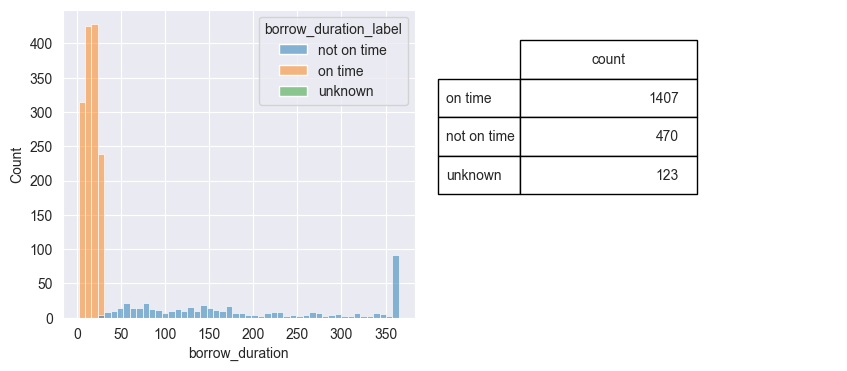

In [112]:
# calculate how long a book was borrowed
checkouts["borrow_duration"] = (
        pd.to_datetime(checkouts["date_returned"]) -
        pd.to_datetime(checkouts["date_checkout"])
).dt.days.abs()

# create label was a book returned on time, not on time ot the status is unknown
borrow_threshold = 28
checkouts["borrow_duration_label"] = "unknown"
checkouts.loc[checkouts["borrow_duration"] > borrow_threshold, "borrow_duration_label"] = "not on time"
checkouts.loc[checkouts["borrow_duration"] <= borrow_threshold, "borrow_duration_label"] = "on time"

# plot histogram and show label counts
label_counts = checkouts["borrow_duration_label"].value_counts().to_frame()
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.histplot(data=checkouts, x="borrow_duration", hue="borrow_duration_label",  bins=50, ax=axs[0])
axs[1].axis('off')
mpl_table = axs[1].table(cellText = label_counts.values, rowLabels = label_counts.index,
                         bbox=[0.1, 0.4, 0.5, 0.5], colLabels=label_counts.columns)

The histogram shows that the population of customers who don't return books on time tends to have a uniform distribution.
<br>
### Borrow Count
This feature should provide the basic insight into book's history. 

Correlation not_on_time_count_relative vs borrow_duration: 0.6268566130376858


<Axes: xlabel='not_on_time_count_relative'>

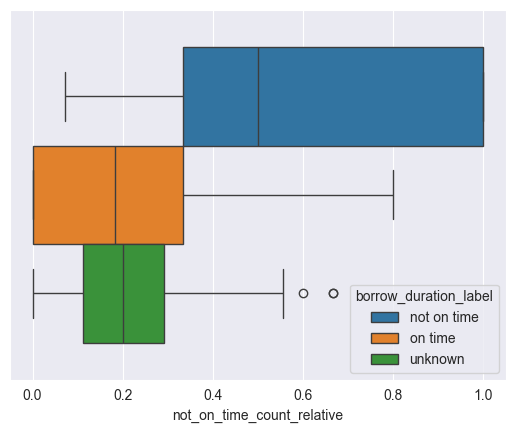

In [113]:
checkouts["borrow_count"] = checkouts.groupby("title").cumcount() + 1
checkouts["not_on_time"] = checkouts["borrow_duration_label"] == "not on time"
checkouts["not_on_time_count"] = checkouts.groupby("title")["not_on_time"].cumsum()
checkouts["not_on_time_count_relative"] = checkouts["not_on_time_count"] / checkouts["borrow_count"]

correlation = float(checkouts["not_on_time_count_relative"].corr(checkouts["borrow_duration"]))
print(f"Correlation not_on_time_count_relative vs borrow_duration: {correlation}")

sns.boxplot(data=checkouts, x="not_on_time_count_relative", hue="borrow_duration_label")

The ratio of number of not on time returns and total number of borrows correlates with the labels, but due to its direct link with the target it potentially can force the model to overfit or excessive dependence on this feature. Therefore, this historical insight should be more generalised and defined as books features (how often a book is not returned on time, etc.)

Correlation not_on_time_rate vs borrow_duration: 0.291608647558271
P-value for not_on_time_rate: 1.7536705335898712e-60


<Axes: xlabel='not_on_time_rate'>

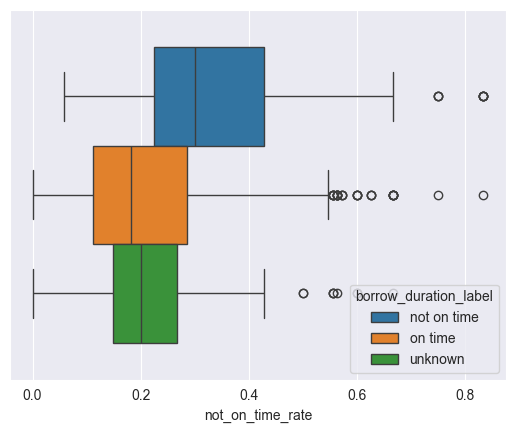

In [114]:
checkouts["not_on_time"] = checkouts["borrow_duration_label"] == "not on time"
not_on_time_rate = checkouts.groupby("title")["not_on_time"].sum() / checkouts["title"].value_counts()
not_on_time_rate.name = "not_on_time_rate"
not_on_time_rate = not_on_time_rate.to_frame()
checkouts = checkouts.merge(not_on_time_rate, how="left", left_on="title", right_on="title")

correlation = float(checkouts["not_on_time_rate"].corr(checkouts["borrow_duration"]))
print(f"Correlation not_on_time_rate vs borrow_duration: {correlation}")

t, p_value = ttest_ind(
    checkouts.loc[~checkouts["not_on_time"], "not_on_time_rate"],
    checkouts.loc[checkouts["not_on_time"], "not_on_time_rate"]
)
print(f"P-value for not_on_time_rate: {p_value}")

sns.boxplot(data=checkouts, x="not_on_time_rate", hue="borrow_duration_label")


The boxplot shows that the not_on_time_rate book correlates sufficiently and has a small p-value that indicates its usability in the next step.
<br>
### Seasons
I want to check if part of the year (quarter, season or month) influences prolonged book borrowing. 

In [115]:
# Seasons
date = pd.to_datetime(checkouts["date_checkout"])
checkouts["quarter"] = pd.cut(date.dt.month, bins=[0, 3, 6, 9, 12], labels=["Q1", "Q2", "Q3", "Q4"])
days = (date.dt.month*100 + date.dt.day - 130)%1300
checkouts["season"] = pd.cut(days, bins=[0, 300, 602, 900, 1300], labels=['spring', 'summer', 'autumn', 'winter'])

contingency_season = pd.crosstab(checkouts["season"], checkouts["borrow_duration_label"])
chi2_season, p_season, dof_season, expected_season = chi2_contingency(contingency_season)

contingency_quarter = pd.crosstab(checkouts["quarter"], checkouts["borrow_duration_label"])
chi2_quarter, p_quarter, dof_quarter, expected_quarter = chi2_contingency(contingency_quarter)

print(f"Season - Chi2: {chi2_season}, p-value: {p_season}\nQuarter - Chi2: {chi2_quarter}, p-value: {p_quarter}")
pd.crosstab(checkouts["season"], checkouts["borrow_duration_label"])

Season - Chi2: 3.6890923711238077, p-value: 0.7186651654900678
Quarter - Chi2: 3.1757568450108438, p-value: 0.7864862376476867


borrow_duration_label,not on time,on time,unknown
season,,,
spring,120,356,15
summer,107,375,15
autumn,119,311,13
winter,121,360,15


In [81]:
checkouts.groupby("season", observed=False)["borrow_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
spring,476.0,64.321429,102.086154,5.0,13.0,19.0,29.25,365.0
summer,482.0,51.917012,87.342620,4.0,12.0,19.0,26.00,365.0
autumn,430.0,67.086047,101.292807,2.0,13.0,20.5,58.50,365.0
winter,481.0,57.118503,91.314569,2.0,11.0,20.0,42.00,365.0


In [82]:
thr = checkouts["borrow_duration"].quantile(0.9)
checkouts[checkouts["borrow_duration"] < thr].groupby("season", observed=False)["borrow_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
spring,418.0,29.334928,37.173748,5.0,12.0,18.0,25.0,186.0
summer,448.0,30.500000,38.508839,4.0,11.0,18.0,24.0,196.0
autumn,377.0,32.949602,41.761418,2.0,13.0,18.0,25.0,195.0
winter,438.0,31.621005,39.736175,2.0,11.0,18.5,26.0,191.0


In [83]:
checkouts[checkouts["borrow_duration"] < thr].groupby("quarter", observed=False)["borrow_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
quarter,,,,,,,,
Q1,438.0,29.463470,37.333395,5.0,12.0,18.0,25.0,187.0
Q2,429.0,29.937063,36.901400,4.0,12.0,18.0,24.0,195.0
Q3,414.0,33.676329,42.485851,2.0,12.0,19.0,25.0,196.0
Q4,407.0,31.653563,40.699432,2.0,11.0,18.0,25.0,191.0


In [84]:
month = pd.concat([date.dt.month, checkouts["borrow_duration"], checkouts["borrow_duration_label"]], axis=1)
month.rename(columns={"date_checkout": "month"}, inplace=True)
month[month["borrow_duration"] < thr].groupby("month", observed=False)["borrow_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1.0,157.0,32.305732,39.577199,5.0,12.00,19.0,26.0,187.0
2.0,129.0,28.434109,37.162827,5.0,11.00,17.0,25.0,177.0
3.0,152.0,27.401316,35.087640,5.0,12.00,18.0,24.0,185.0
4.0,133.0,32.804511,39.940763,5.0,13.00,18.0,25.0,186.0
5.0,149.0,26.362416,29.609671,4.0,12.00,18.0,23.0,195.0
6.0,147.0,30.965986,40.487511,5.0,11.00,18.0,24.5,185.0
7.0,152.0,34.105263,43.765352,4.0,11.75,18.5,25.0,196.0
8.0,138.0,31.971014,40.260637,5.0,13.00,18.0,24.0,184.0
9.0,124.0,35.048387,43.573106,2.0,12.75,20.0,26.0,195.0


Due to high p values (>0.05), these parameters can be considered as not highly correlated with the label. Additionally, visual inspection of the crosstab indicates an almost even distribution between categories. I also tried to aggregate borrowing periods by seasons and months and see if there is any specific period with a prolonged borrowing time. Initially, some periods differed from the others. After further inspection (high standard deviation and reduced difference after removing outliers), I will keep just the "season" column in case the model could combine it with other features, but, in general, the season-related features can be rejected. 
<br>
### Customer's Age
I want to calculate the customer's age at the moment of book borrowing.

In [116]:
# Customers age in the moment of a checkout
checkouts["customers_age"] = (
        pd.to_datetime(checkouts["date_checkout"]).dt.year -
        pd.to_datetime(checkouts["birth_date"]).dt.year
).abs()
checkouts.drop(["date_checkout", "date_returned", "birth_date"], axis=1, inplace=True)

correlation = float(checkouts["customers_age"].corr(checkouts["borrow_duration"]))
print(f"Correlation customers_age vs borrow_duration: {correlation}")

Correlation customers_age vs borrow_duration: -0.0042989246951765925



Customer's age and borrowing duration are not highly correlated.
###
### Geographical Features
Using longitude and latitude coordinates I want to calculate distances between libraries and customers. For that purpose I will use Haversine formula.

Correlation distance vs borrow_duration: 0.12073322519689159


<Axes: xlabel='distance', ylabel='Count'>

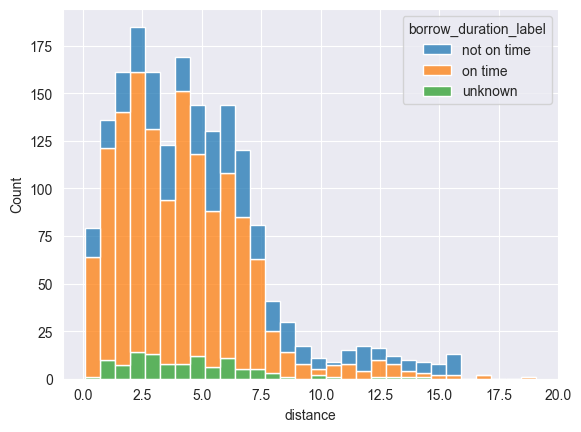

In [117]:
checkouts["distance"] = checkouts.apply(lambda row: calculate_distance(loc1=row["coordinates_libraries"], loc2=row["coordinates_customers"]), axis=1)
checkouts.drop(["coordinates_libraries", "coordinates_customers"], axis=1, inplace=True)

correlation = float(checkouts["distance"].corr(checkouts["borrow_duration"]))
print(f"Correlation distance vs borrow_duration: {correlation}")

sns.histplot(data=checkouts, x="distance", hue="borrow_duration_label", multiple='stack')

<Axes: xlabel='distance', ylabel='name'>

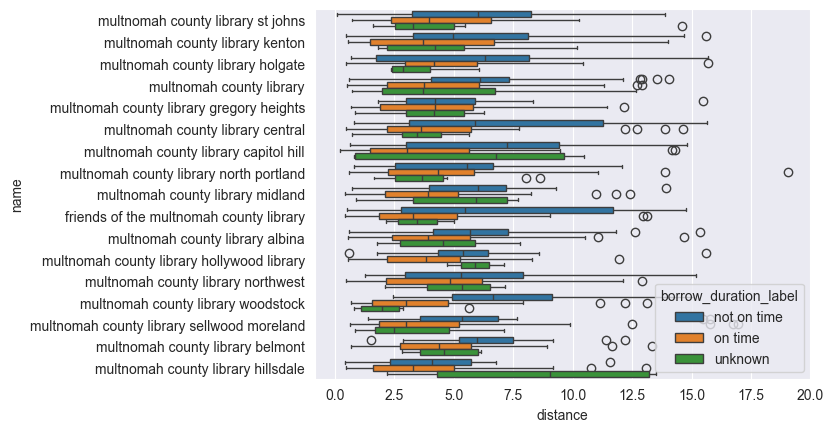

In [118]:
sns.boxplot(data=checkouts, x="distance", y="name", hue="borrow_duration_label")

 The correlation is not so high for the whole dataset, but some subsets probably correlate. The boxplot shows that for some libraries, "not on time" labels have average higher distances than the others.
###
### Other Customer's Characteristics
 The other categorical parameters (education, occupation, gender) could be useful in defining specific subsets. Maybe some specific customer profile tends to keep a book longer. 

In [119]:
pd.crosstab([checkouts["occupation"], checkouts["education"], checkouts["gender"]], checkouts["borrow_duration_label"])

borrow_duration_label               not on time  on time  unknown
occupation education       gender                                
admin      college         female             4       20        4
                           male              20       41        2
                           unknown            0        1        0
           graduate degree female            13       39        8
                           male               9       23        1
...                                         ...      ...      ...
tech       high school     male              14       31        1
                           unknown            1        0        0
           others          female             9       21        0
                           male               7       19        2
                           unknown            0        1        0

[82 rows x 3 columns]

<Axes: xlabel='occupation', ylabel='distance'>

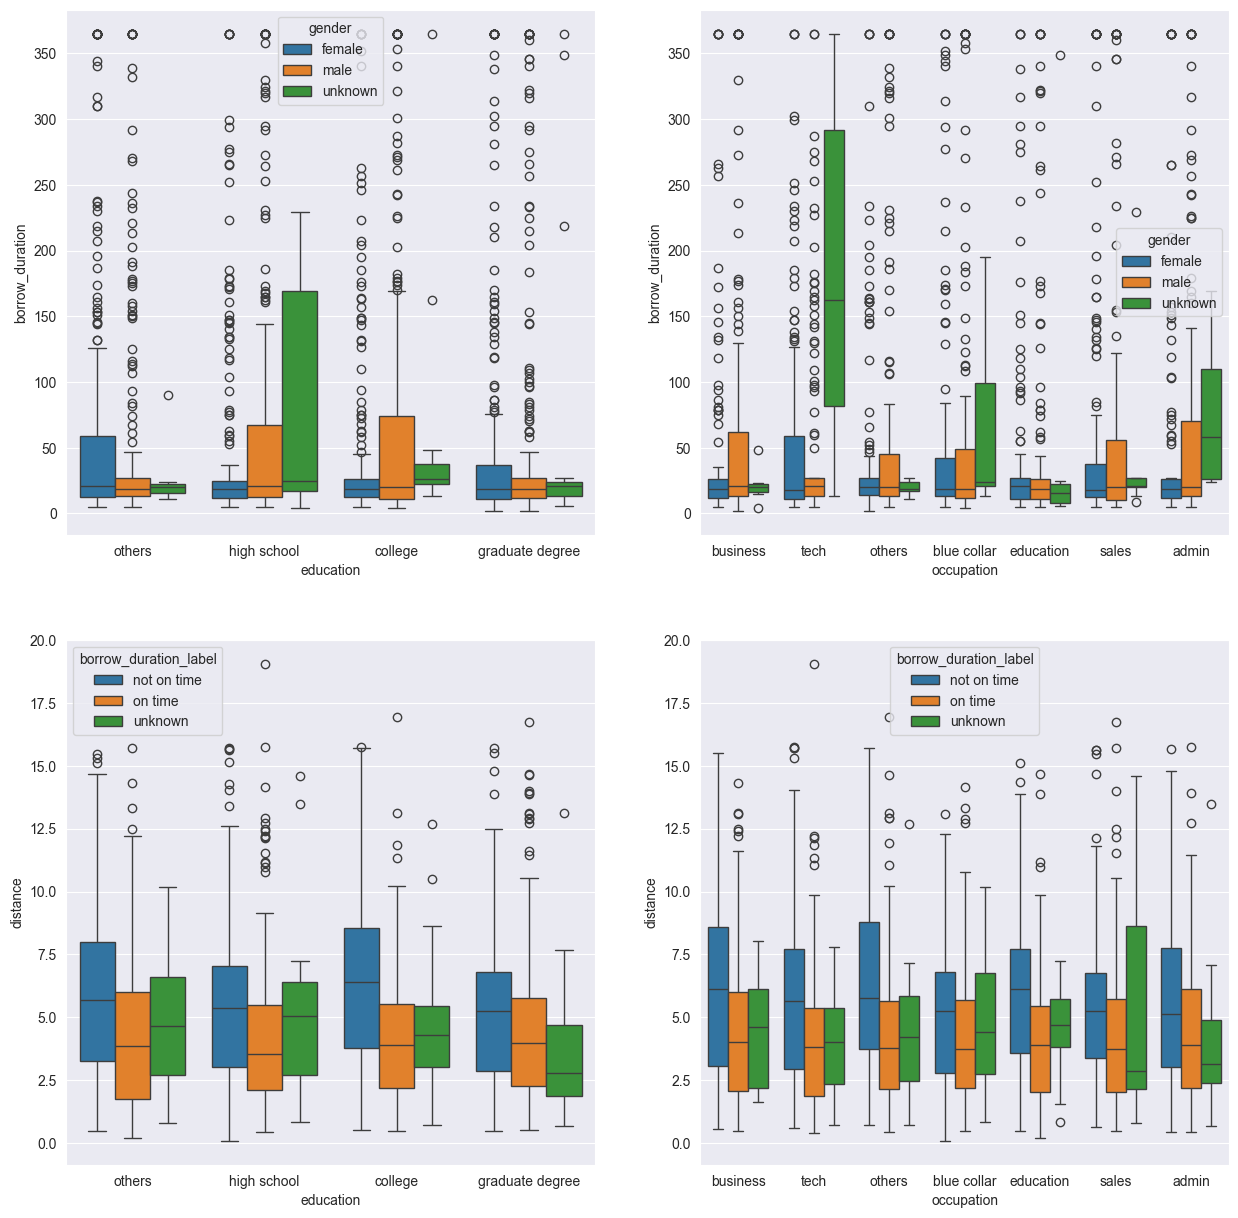

In [120]:
fig_3, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
sns.boxplot(data=checkouts, x="education", y="borrow_duration", hue="gender", ax=axs[0, 0])
sns.boxplot(data=checkouts, x="occupation", y="borrow_duration", hue="gender", ax=axs[0, 1])
sns.boxplot(data=checkouts, x="education", y="distance", hue="borrow_duration_label", ax=axs[1, 0])
sns.boxplot(data=checkouts, x="occupation", y="distance", hue="borrow_duration_label", ax=axs[1, 1])

In [88]:
checkouts.groupby(["gender", "occupation", "education"], observed=False)[["customers_age", "distance", "borrow_duration"]].corr()

customers_age  distance  \
gender  occupation education                                                  
female  admin      college         customers_age         1.000000 -0.112700   
                                   distance             -0.112700  1.000000   
                                   borrow_duration       0.184748  0.349056   
                   graduate degree customers_age         1.000000 -0.185705   
                                   distance             -0.185705  1.000000   
...                                                           ...       ...   
unknown tech       high school     distance                   NaN       NaN   
                                   borrow_duration            NaN       NaN   
                   others          customers_age              NaN       NaN   
                                   distance                   NaN       NaN   
                                   borrow_duration            NaN       NaN   

                                                    borrow_duration  
gender  occupation education                                         
female  admin      college         customers_age           0.184748  
                                   distance                0.349056  
                                   borrow_duration         1.000000  
                   graduate degree customers_age           0.063060  
                                   distance               -0.055722  
...                                                             ...  
unknown tech       high school     distance                     NaN  
                                   borrow_duration              NaN  
                   others          customers_age                NaN  
                                   distance                     NaN  
                                   borrow_duration              NaN  

[246 rows x 3 columns]

Although individual parameters don't correlate significantly with borrow duration (or its label), certain combinations of the parameters have a higher correlation index.
<br>
### Book Parameters
The basic book parameter that could be correlated to a prolonged borrowing period is the number of pages (books with more pages need more time to be red). 

Correlation price vs borrow_duration: 0.039503009017211724
Correlation pages vs borrow_duration: 0.028316500668166406
Correlation price vs pages: 0.7410743481002869


<Axes: xlabel='price', ylabel='Count'>

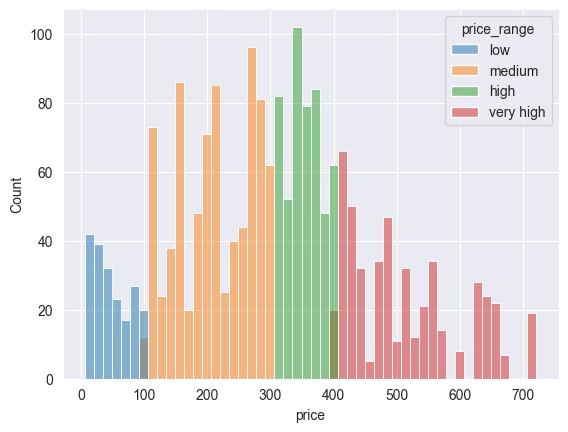

In [121]:
checkouts["price_range"] = pd.qcut(checkouts["price"], q=[0, 0.1, 0.5, 0.75, 1], labels=["low", "medium", "high", "very high"])
checkouts["pages_range"] = pd.qcut(checkouts["pages"], q=[0, 0.1, 0.5, 0.75, 1], labels=["small", "medium", "large", "very large"])

correlation = float(checkouts["price"].corr(checkouts["borrow_duration"]))
print(f"Correlation price vs borrow_duration: {correlation}")

correlation = float(checkouts["pages"].corr(checkouts["borrow_duration"]))
print(f"Correlation pages vs borrow_duration: {correlation}")

correlation = float(checkouts["price"].corr(checkouts["pages"]))
print(f"Correlation price vs pages: {correlation}")

sns.histplot(data=checkouts, x="price", hue="price_range", bins=50)

In [122]:
checkouts.groupby("categories")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
categories,,,,,,,,
advertising,313.0,330.148083,127.798528,25.50,240.99,361.99,420.99,536.99
engines,439.0,275.359043,161.978421,11.50,150.99,274.99,388.00,647.99
financial,251.0,301.263825,149.508417,14.00,233.00,282.50,354.50,650.99
government publication,356.0,341.402275,161.465107,31.00,207.50,364.99,432.50,707.99
mechanics,292.0,314.202260,174.618536,5.99,200.99,305.99,396.99,721.00
medicine,349.0,275.923725,152.514467,21.50,149.99,290.50,347.00,648.00


In [123]:
checkouts.groupby("categories")["pages"].describe()

,count,mean,std,min,25%,50%,75%,max
categories,,,,,,,,
advertising,313.0,612.070288,146.333506,320.0,526.0,635.0,720.0,859.0
engines,439.0,571.712984,179.312575,236.0,416.0,572.0,697.5,932.0
financial,251.0,631.689243,188.214535,353.0,497.0,596.0,752.0,967.0
government publication,356.0,634.553371,162.704606,322.0,530.0,616.0,748.0,1154.0
mechanics,292.0,554.047945,154.325907,305.0,442.0,512.0,658.0,925.0
medicine,349.0,544.441261,156.226681,124.0,410.0,578.0,621.0,900.0


In [124]:
pd.crosstab(checkouts["price_range"], checkouts["pages_range"])

pages_range,small,medium,large,very large
price_range,,,,
low,132,58,10,0
medium,79,509,150,67
high,0,148,216,145
very high,0,77,122,287


<Axes: xlabel='categories', ylabel='borrow_duration'>

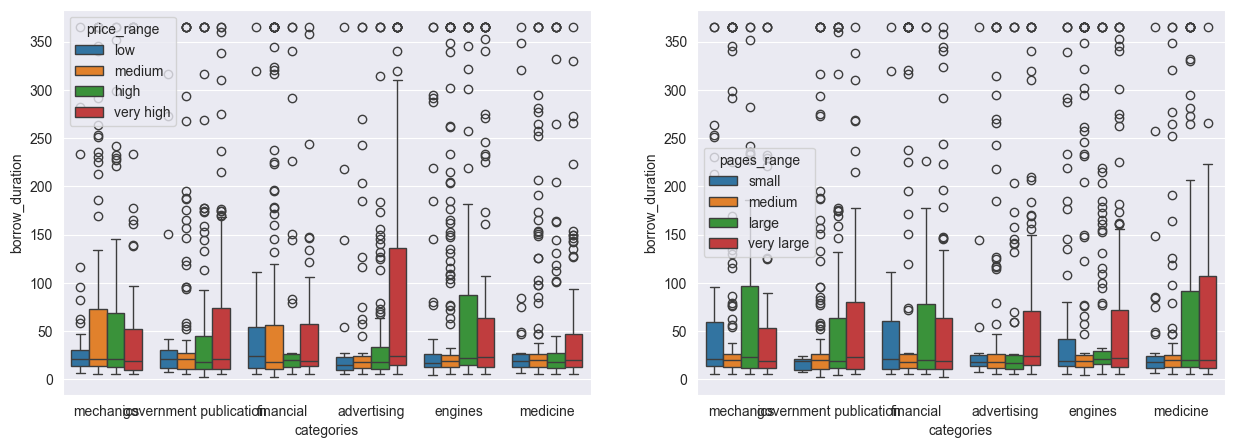

In [125]:
fig_4, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(data=checkouts, x="categories", y="borrow_duration", hue="price_range", ax=axs[0])
sns.boxplot(data=checkouts, x="categories", y="borrow_duration", hue="pages_range", ax=axs[1])

Prices and number of pages are highly correlated, and neither of them globally is correlated to the borrowing period, but, combined with some static features, they could provide some valuable information. For example, medical books with more pages or expensive advertising books tend to stay longer with customers.
<br>
# Final Set Preparation



In [128]:
final_set = checkouts[[
    'gender',
    'education',
    'occupation',
    'categories',
    'price_range',
    'pages_range',
    'season',
    "not_on_time_rate",
    "borrow_duration",
    'borrow_duration_label',
    'distance',
    'name',
]].dropna()
final_set.to_csv("../data/final_set.csv", index=False)